In [1]:
from __future__ import print_function
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
from my_strategy import Strategy
from my_event import SignalEvent
from my_backtest import Backtest
from my_data import HistoricCSVDataHandler
from my_execution import SimulatedExecutionHandler
from my_portfolio import Portfolio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class MovingAverageCrossStrategy(Strategy):
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 100/400 periods respectively.
    """
    def __init__(self, bars, events, short_window=20, long_window=50):
        """
        Initialises the Moving Average Cross Strategy.
        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window
        #Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()
    
    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to ’OUT’.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        
        if event.type == 'MARKET':
            for s in self.symbol_list:
                bars = self.bars.get_latest_bars_values(
                s, "adj_close", N=self.long_window
                )
                bar_date = self.bars.get_latest_bar_datetime(s)
               
                if bars is not None:
               
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])
                    symbol = s
                    dt = datetime.datetime.utcnow()
                    #print(dt)
                    sig_dir = ""
                    if short_sma > long_sma and self.bought[s] == "OUT":
                        print("LONG: %s" % bar_date)
                        print("short-ma: ", short_sma, " long_ma: ", long_sma)
                        sig_dir = 'LONG'
                        signal = SignalEvent(1, symbol, dt, sig_dir, 1.0)
                        self.events.put(signal)
                        self.bought[s] = 'LONG'
                    elif short_sma < long_sma and self.bought[s] == "LONG":
                        print("SHORT: %s" % bar_date)
                        print("short-ma: ", short_sma, " long_ma: ", long_sma)
                        sig_dir = 'EXIT'
                        signal = SignalEvent(1, symbol, dt, sig_dir, 1.0)
                        self.events.put(signal)
                        self.bought[s] = 'OUT'

In [5]:
if __name__ == "__main__":
    csv_dir = 'C:/Users/NickLee/quantstart/my_event_driven' # CHANGE THIS!
    symbol_list = ['SPY']
    initial_capital = 1000000.0
    heartbeat = 0.0
    start_date = datetime.datetime(2010, 6, 11, 0, 0, 0)
    end_date = datetime.datetime(2019, 6, 20, 0, 0, 0)
    backtest = Backtest(
    csv_dir, symbol_list, initial_capital, heartbeat,
    start_date, end_date, HistoricCSVDataHandler, SimulatedExecutionHandler,
    Portfolio, MovingAverageCrossStrategy
    )
    backtest.simulate_trading()
    


Creating DataHandler, Strategy, Portfolio and ExecutionHandler
Backtesting start
LONG: 2010-08-02
short-ma:  90.8038444  long_ma:  90.51684844444445
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=BUY
SHORT: 2010-09-02
short-ma:  90.3255853  long_ma:  90.35193956
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=SELL
LONG: 2010-09-21
short-ma:  91.70881084999999  long_ma:  91.68628313999997
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=BUY
SHORT: 2011-03-23
short-ma:  110.11159364999999  long_ma:  110.11234693999997
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=SELL
LONG: 2011-04-13
short-ma:  111.26809739999999  long_ma:  111.13945267999999
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=BUY
SHORT: 2011-06-06
short-ma:  112.74952350000001  long_ma:  112.78194349999994
Order: Symbol=SPY, Type=MKT, Quantity=1000, Direction=SELL
LONG: 2011-07-19
short-ma:  111.69523505000002  long_ma:  111.47657514000001
Order: Symbol=SPY, Type=MKT, Quantity=1000, Directio

In [4]:
backtest.portfolio.all_holdings

[{'SPY': 0.0,
  'cash': 100000.0,
  'commission': 0.0,
  'datetime': datetime.datetime(2018, 6, 11, 0, 0),
  'total': 100000.0},
 {'SPY': 0.0,
  'cash': 100000.0,
  'commission': 0.0,
  'datetime': '2018-06-11',
  'total': 100000.0},
 {'SPY': 0.0,
  'cash': 100000.0,
  'commission': 0.0,
  'datetime': '2018-06-12',
  'total': 100000.0},
 {'SPY': 271418.63999999996,
  'cash': -172295.506,
  'commission': 8.0,
  'datetime': '2018-06-13',
  'total': 99123.13399999996},
 {'SPY': 0.0,
  'cash': 99115.13399999996,
  'commission': 16.0,
  'datetime': '2018-06-14',
  'total': 99115.13399999996},
 {'SPY': 271754.913,
  'cash': -172994.88600000006,
  'commission': 24.0,
  'datetime': '2018-06-15',
  'total': 98760.02699999994},
 {'SPY': 0.0,
  'cash': 98752.02699999994,
  'commission': 32.0,
  'datetime': '2018-06-18',
  'total': 98752.02699999994},
 {'SPY': 0.0,
  'cash': 98752.02699999994,
  'commission': 32.0,
  'datetime': '2018-06-19',
  'total': 98752.02699999994},
 {'SPY': 0.0,
  'cash': 

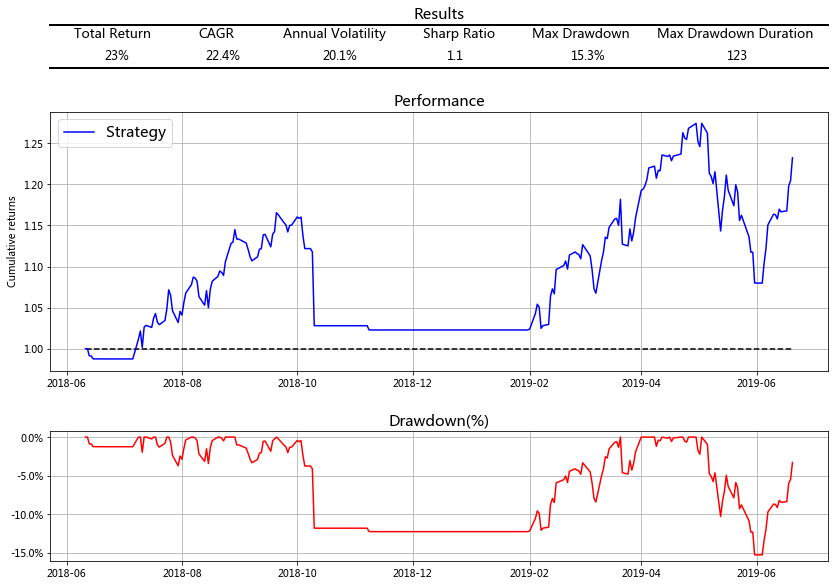

In [12]:
backtest.plot_results()

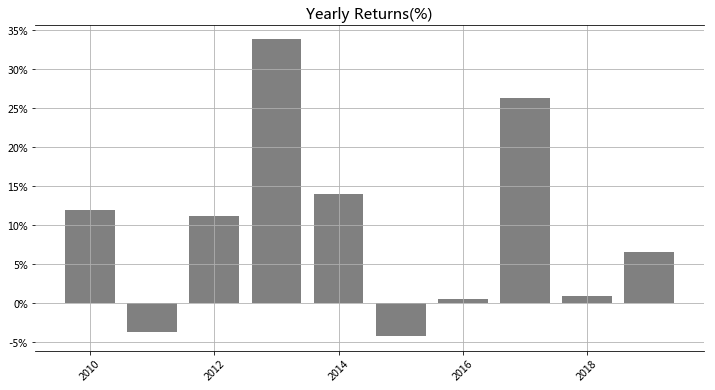

In [7]:
backtest.plot_yearly_returns()

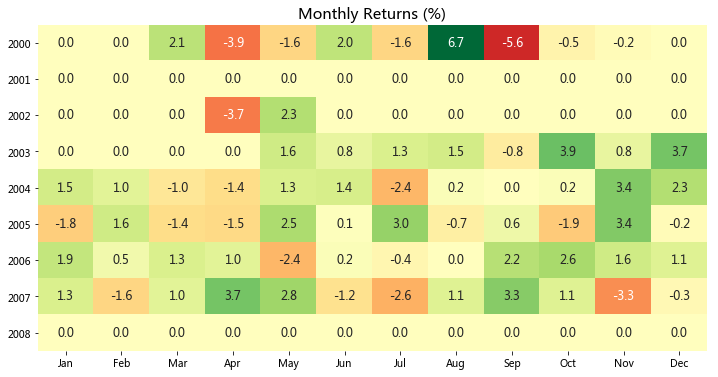

In [6]:
backtest.plot_monthly_returns()

# 調整圖

In [7]:
returns = backtest.portfolio.equity_curve[['returns']]

In [8]:
returns.tail()

,returns
datetime,
2018-09-25,-0.001131
2018-09-26,-0.003647
2018-09-27,0.003408
2018-09-28,0.000126
2018-10-01,0.004234


In [9]:
def return_by_period(df, period='year'):
    '''
    rearange data based on different time frame 
    '''
    returns = df.copy().dropna()
    if period == 'year':
        returns[period] = [s.year for s in returns.index]
        returns = returns.groupby('year').apply(lambda data: np.cumprod(1+data['returns']).iloc[-1]-1)
    elif period == 'month':
        returns['year'] = [s.year for s in returns.index]
        returns['month'] = [s.month for s in returns.index]
        returns = returns.set_index(['year', 'month'])
        returns = returns.groupby(['year','month']).apply(lambda data: np.cumprod(1+data['returns']).iloc[-1]-1)
    return returns

In [10]:
returns = backtest.portfolio.equity_curve[['returns']]
yearly_return = return_by_period(returns, period='year')
monthly_return = return_by_period(returns, period='month')
monthly_return = monthly_return.unstack()

In [11]:
backtest.portfolio.equity_curve.tail()

,SPY,cash,commission,total,returns,equity_curve,drawdown
datetime,,,,,,,
2018-09-25,286401.337,-51411.08,72.0,234990.257,-0.001131,2.349903,0.006278
2018-09-26,285544.403,-51411.08,72.0,234133.323,-0.003647,2.341333,0.009901
2018-09-27,286342.255,-51411.08,72.0,234931.175,0.003408,2.349312,0.006527
2018-09-28,286371.826,-51411.08,72.0,234960.746,0.000126,2.349607,0.006402
2018-10-01,287366.730,-51411.08,72.0,235955.650,0.004234,2.359556,0.002195


In [12]:
def create_returns_and_sharpe_ratio(returns, periods=252):
    """
    Create the Returns and Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).

    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    
    tot_ret = np.cumprod(1+returns).iloc[-1]-1
    years = len(returns)/periods
    cagr = (tot_ret+1)**(1/years)-1
    anul_std = returns.std()*np.sqrt(periods)
    sharpe = cagr / anul_std
    return tot_ret[0], cagr[0], anul_std[0], sharpe[0]

In [13]:
def create_drawdowns(pnl):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = pnl.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], pnl[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - pnl[t]
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1] + 1)
    return drawdown, drawdown.max(), duration.max()

In [14]:
returns = temp[['returns']]
pnl = temp['equity_curve']
tot_ret, cagr, std, sharpe = create_returns_and_sharpe_ratio(returns)
drawdown, max_dd, dd_duration = create_drawdowns(pnl)

NameError: name 'temp' is not defined

In [ ]:
std

NameError: name 'tot_ret' is not defined

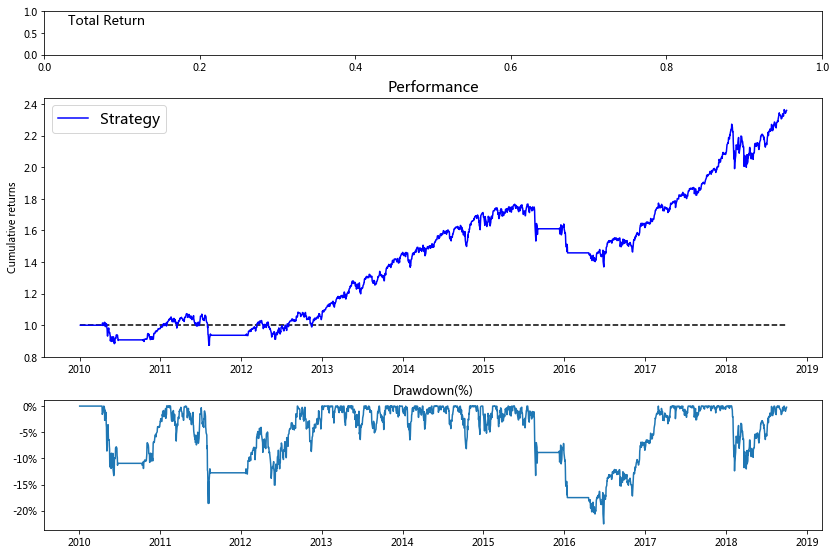

In [15]:
plt.figure(figsize = (12, 12))

rect1 = [0.14, 0.55, 0.9, 0.30] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.35, 0.9, 0.15]
rect5 = [0.14, 0.90, 0.9, 0.05]

ax1 = plt.axes(rect1)
ax1.plot(backtest.portfolio.equity_curve['equity_curve'], color='b')
ax1.set_title('Performance', fontsize=15)
ax1.legend(['Strategy'], loc='upper left',  fontsize=15)
ax1.hlines(1, linestyles='--', xmin=backtest.start_date, xmax=backtest.end_date)
ax1.set_ylabel('Cumulative returns')

ax2 = plt.axes(rect2)
ax2.set_title('Drawdown(%)', fontsize=12)
ax2.plot(-backtest.portfolio.equity_curve['drawdown'])
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))


ax5 = plt.axes(rect5)
ax5.text(0.03, 0.7, 'Total Return', fontsize=13)
ax5.text(0.07, 0.2, '{:.0%}'.format(tot_ret), fontsize=12)
ax5.text(0.19, 0.7, 'CAGR', fontsize=13)
ax5.text(0.20, 0.2, '{:.1%}'.format(cagr), fontsize=12)
ax5.text(0.30, 0.7, 'Annual Volatility', fontsize=13)
ax5.text(0.35, 0.2, '{:.1%}'.format(std), fontsize=12)
ax5.text(0.48, 0.7, 'Sharp Ratio', fontsize=13)
ax5.text(0.51, 0.2, '{:.1f}'.format(sharpe), fontsize=12)
ax5.text(0.62, 0.7, 'Max Drawdown', fontsize=13)
ax5.text(0.67, 0.2, '{:.1%}'.format(max_dd), fontsize=12)
ax5.text(0.78, 0.7, 'Max Drawdown Duration', fontsize=13)
ax5.text(0.87, 0.2, '{:.0f}'.format(dd_duration), fontsize=12)
ax5.grid(False)
ax5.spines['top'].set_linewidth(2.0)
ax5.spines['bottom'].set_linewidth(2.0)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
ax5.set_ylabel('')
ax5.set_xlabel('')
ax5.set_title('Results', fontweight='bold', fontsize=16)

plt.show()

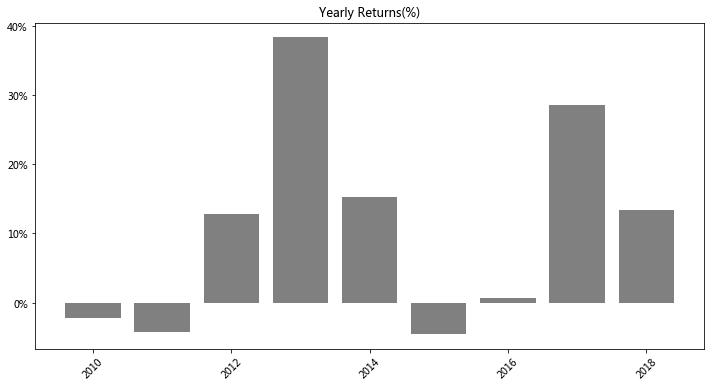

In [16]:
plt.figure(figsize = (12, 6))
ax = plt.gca()
ax.set_title('Yearly Returns(%)', fontsize=12)
ax.bar(yearly_return.index, yearly_return, color='gray')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_xticklabels([int(x) for x in ax.get_xticks()], rotation=45)
plt.show()

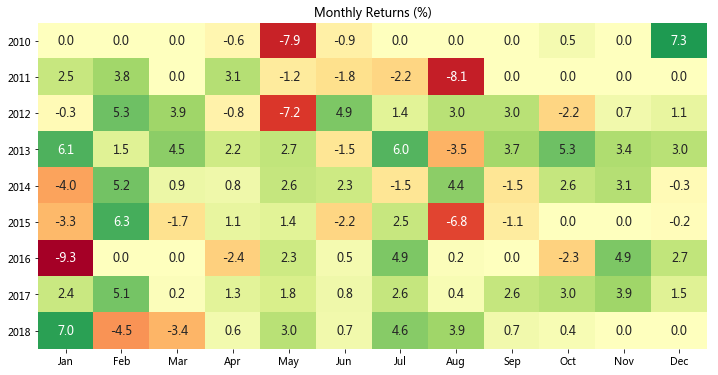

In [24]:
plt.figure(figsize = (12, 6))
ax = plt.gca()
monthly_return = np.round(monthly_return, 3)
monthly_return.rename(
    columns={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
             5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
             9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'},
    inplace=True
)
sns.heatmap(
            monthly_return.fillna(0) * 100.0,
            annot=True,
            fmt="0.1f",
            annot_kws={"size": 12},
            alpha=1.0,
            center=0.0,
            cbar=False,
            cmap=cm.RdYlGn,
            ax=ax)
ax.set_title('Monthly Returns (%)', fontsize=12)
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('')

plt.show()

In [20]:
sns.heatmap?